# Pricing A/B Testing - Donald Lee-Brown

Originally a mock data challenge completed as part of the 2018B NYC [Insight Data Science Fellows Program](https://www.insightdatascience.com). 

The goal of this project is to generate insights from an A/B test that presented a random subset (the test group) of users with a higher price for a software product. The responses of these customers, as well as those of a control group shown the normal software price, were recorded along with some other information over a period of three months. 

Key questions addressed by this project:
* What is the impact on conversion rate due to increasing the price of the software?
* What is the impact on overall revenue due to increasing the price of the software?
* Can A/B testing be made more efficient in the future by estimating how much data is needed to detect test/control differences at a significant level?
* What are some other insights from the data that can be used to increase customer conversion rate?

The project is organized into several sections:
* Data cleaning and exploration 
* The impact of software price on conversion rate and revenue
* Other insights
* Conclusion

In [1]:
# imports used in the notebook
import pandas as pd
import seaborn as sns
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import math
from scipy import stats as spst
from scipy.stats import chisquare
sns.set_style("darkgrid")

## 1. Data cleaning and exploration

There are two data tables - one (test_results) contains information regarding customer info, which software price they were shown, and whether or not they opted to purchase the software. The second table (user_table) contains location information for users. 

### Reading in, joining, and looking for missing values

First read in the data. We know that we can expect test_results and user_table to be joinable on user_id, but we need to check to make sure this can be done uniquely. This means we should check to make sure there are no duplicates in user_id (especially since it's not impossible that the same user would buy the software twice):

In [2]:
test_results = pd.read_csv('test_results.csv')
user_table = pd.read_csv('user_table.csv')

print(test_results[test_results.duplicated(subset=['user_id'])])
print(user_table[user_table.duplicated(subset=['user_id'])])

Empty DataFrame
Columns: [Unnamed: 0, user_id, timestamp, source, device, operative_system, test, price, converted]
Index: []
Empty DataFrame
Columns: [user_id, city, country, lat, long]
Index: []


Great - both tables have unique values for user_id (user_id is not duplicated), so we can straightforwardly join them. 

Once we do that, we can take a look at the joined data:

In [3]:
test_results.set_index('user_id', inplace=True)
user_table.set_index('user_id', inplace=True)
joined_test_users = test_results.join(user_table)
joined_test_users.drop(columns = joined_test_users.columns[0], inplace=True)
joined_test_users.head()

,timestamp,source,device,operative_system,test,price,converted,city,country,lat,long
user_id,,,,,,,,,,,
604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39.0,0,Buffalo,USA,42.89,-78.86
624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39.0,0,Lakeville,USA,44.68,-93.24
317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39.0,0,Parma,USA,41.38,-81.73
685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59.0,0,Fayetteville,USA,35.07,-78.90
820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39.0,0,Fishers,USA,39.95,-86.02


From the above table, we can see the various columns described in the data documentation, but it is also apparent that there are some issues with the data - for example the source column mixes underscores and dashes, which was not indicated in the documentation.

We will make sure the data is clean later - for now let's check for missing values:

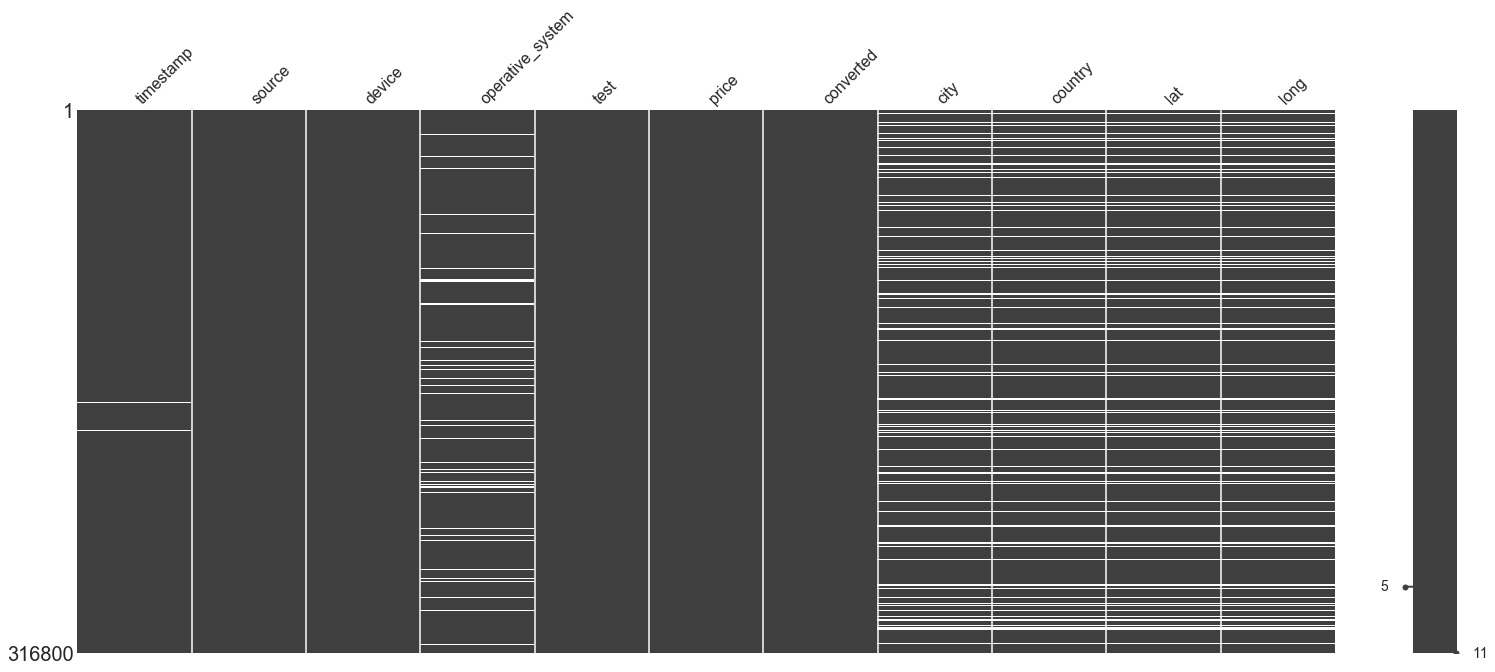

In [4]:
msno.matrix(joined_test_users)

In the above diagram, the horizontal lines indicate missing values. There are quite a few missing values, mostly in the user table. It also looks like there are a few missing timestamps - we can just remove these as they represent a small fraction of the total data. Operative system is also missing quite a few values (5% of data in fact) - we don't want to throw this away, and will deal with it in the steps below. 

Drop the missing timestamps:

In [5]:
joined_test_users = joined_test_users.dropna(subset=['timestamp'])

### Data cleaning and converting categorical variables

Now we need to make sure the joined set is clean. A few quick diagnostics (not shown here) reveal that there are several issues to be fixed before proceeding:
* The timestamp column is generally in accordance with datetime format, but some years are labeled as 2815 instead of 2015. Additionally, some of the times go to 60 mins/60 seconds - I changed these to 59 instead. 
* In the source column there isn't standardization between dash and underscore instances: change them all to underscores for consistency. 
* There are some typos in the operative_system column - I can just fix these via replacement. 
* Linux and Other are missing from operative_system, and there are many missing values as noted above - replace the missing values with "Other" as a catch-all category (some of these in Other may actually be windows/mac, etc. but set them to Other for now). 
* Some price information appears to be incorrect - values way higher than 59 dollars. As I don't know what the price should have been, I will exclude these rows. 

For now, because of all the missing data, we'll exclude the customer demographics information from the analysis.

In [6]:
# fix timestamp issue
joined_test_users['timestamp'] = joined_test_users['timestamp'].str.replace('2815', '2015')
joined_test_users['timestamp'] = joined_test_users['timestamp'].str.replace('60', '59')
joined_test_users['timestamp'] = joined_test_users['timestamp'].astype('datetime64')

# fix - and _ issue
joined_test_users['source'] = joined_test_users['source'].str.replace('-', '_')

# replace typos in operative_system column
joined_test_users['operative_system'] = joined_test_users['operative_system'].str.replace('i0S', 'iOS')
joined_test_users['operative_system'] = joined_test_users['operative_system'].str.replace('wnddows', 'windows')
joined_test_users['operative_system'] = joined_test_users['operative_system'].str.replace('anroid', 'android')
joined_test_users['operative_system'] = joined_test_users['operative_system'].str.replace('apple', 'mac')
joined_test_users['operative_system'] = joined_test_users['operative_system'].str.replace('apple', 'mac')
joined_test_users['operative_system'] = joined_test_users['operative_system'].fillna('Other')

# select only 39/59 prices
joined_test_users = joined_test_users[joined_test_users['price'] <= 60.0]  


/anaconda3/lib/python3.6/site-packages/pandas/core/internals.py:3462: FutureWarning: Passing in 'datetime64' dtype with no frequency is deprecated and will raise in a future version. Please pass in 'datetime64[ns]' instead.
  return self.apply('astype', dtype=dtype, **kwargs)


Now with cleaned data, it will be helpful to map the categorical variables (source, operating system, and device) to numerical values. This can be done by assigning a numerical value to each category in the aforementioned columns:

In [7]:
# encode everything
opsys_cats = {'mac': 0, 'windows': 1, 'iOS': 2, 'android': 3, 'Other': 4}
source_cats = {'ads_google': 0, 'ads_facebook': 1, 'ads_bing': 2, 'ads_yahoo': 3, 'ads_other': 4, 'seo_google': 5,
              'seo_facebook': 6, 'seo_bing': 7, 'seo_yahoo': 8, 'seo_other': 9, 'friend_referral': 10,
               'direct_traffic': 11}
device_cats = {'mobile': 0, 'web': 1}

joined_test_users['operative_system'].replace(opsys_cats, inplace=True)
joined_test_users['source'].replace(source_cats, inplace=True)
joined_test_users['device'].replace(device_cats, inplace=True)

joined_test_users.head()

,timestamp,source,device,operative_system,test,price,converted,city,country,lat,long
user_id,,,,,,,,,,,
604839,2015-05-08 03:38:34,1.0,0,2,0,39.0,0,Buffalo,USA,42.89,-78.86
624057,2015-05-10 21:08:46,5.0,0,3,0,39.0,0,Lakeville,USA,44.68,-93.24
317970,2015-04-04 15:01:23,2.0,0,3,0,39.0,0,Parma,USA,41.38,-81.73
685636,2015-05-07 07:26:01,11.0,0,2,1,59.0,0,Fayetteville,USA,35.07,-78.90
820854,2015-05-24 11:04:40,1.0,1,0,0,39.0,0,Fishers,USA,39.95,-86.02


### Defining the control/test sets and ensuring they are not biased

With our data cleaned and categorical variables mapped to numerical values, we can now split into the A/B groups - those that saw the 39 dollar price (control) and those that saw the 59 dollar price (test).

In [8]:
control_group = joined_test_users[joined_test_users['price'] == 39.0]
test_group = joined_test_users[joined_test_users['price'] == 59.0]

Before we dive into the analysis, it's critical to make sure that the testing and training samples are similar to one another in order to control for variables like time distributions, device choice, etc. (even with large samples like this). Key questions we need to answer when comparing the control/test groups:

* Do time distributions look the same?
* Are operating systems the same?
* Are devices the same?
* Are sources the same?

This is very important to confirm since one could imagine a scenario in which the test set is dominated by mobile users who are less likely to buy the software. 

The statistical test for this, since we are testing two categorical datasets, is Chi-squared, but it can be informative to just give the distributions a quick look to see if they are the same. Later on, if the significance of our eventual metrics is near our adopted threshold, we may want to be more rigorous with testing these distributions.

As an example of this quick analysis, we can plot the time distribution of the test and control groups to reveal that the distributions are very similar, so we don't need to immediately test for significance. There is a small increase in users in May but this is reflected in both test and control samples. 

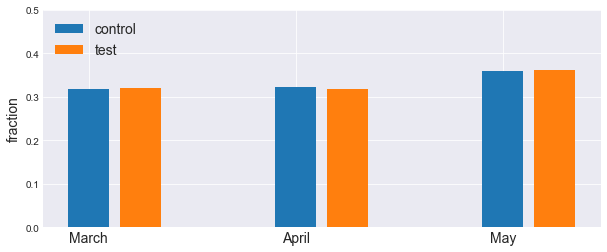

In [9]:
grouped_by_month_control = control_group['timestamp'].groupby(control_group['timestamp'].dt.month).count()
grouped_by_month_control = grouped_by_month_control/sum(grouped_by_month_control)

grouped_by_month_test = test_group['timestamp'].groupby(test_group['timestamp'].dt.month).count()
grouped_by_month_test = grouped_by_month_test/sum(grouped_by_month_test)

x1 = [1, 5, 9]
x2 = [2, 6, 10]
fig, ax = plt.subplots(figsize=(10,4))
plt.bar(x1, grouped_by_month_control, label='control')
plt.bar(x2, grouped_by_month_test, label='test')
plt.xticks(x1, ('March', 'April', 'May'), fontsize=14)
plt.ylabel('fraction', fontsize=14)
plt.legend(loc=2, fontsize=14)
plt.ylim([0.0, 0.5])
plt.show()

We can do this for the other variables (operating system, source, device) to confirm that the distributions of control and test samples in the various categories are consistent - just operating system results are shown below. 

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  after removing the cwd from sys.path.


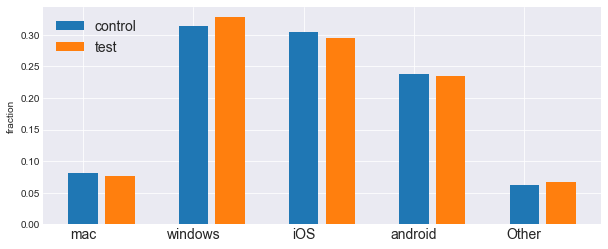

In [11]:
def onehot_encode_function(categorical_column):
    onehot_encoder = OneHotEncoder(sparse=False)
    encoded = categorical_column.dropna()
    encoded = encoded.reshape(len(encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(encoded)
    return(onehot_encoded)

onehot_opsys_control = onehot_encode_function(control_group['operative_system'])
onehot_opsys_test = onehot_encode_function(test_group['operative_system'])

fig, ax = plt.subplots(figsize=(10,4))
plt.bar(np.arange(0, 15, 3), np.sum(onehot_opsys_control, axis=0)/np.sum(onehot_opsys_control), label='control')
plt.bar(np.arange(1, 16, 3), np.sum(onehot_opsys_test, axis=0)/np.sum(onehot_opsys_test), label='test')
plt.xticks(np.arange(0, 15, 3),list(opsys_cats.keys()), fontsize=14)
plt.legend(loc=2, fontsize=14)
plt.ylabel('fraction')
plt.show()

At this point, we have our data loaded in and cleaned, and we've mapped our categorical variables we'll use later to numerical values. We've also confirmed that our control and test sets do not appear to be systematically biased when compared with one another. 

# 2. The impact of software price on conversion rate and revenue

### Testing conversion rate differences

We can now start our analysis. The first question we are interested in answering is whether or not the conversion rate went down for the higher-price group relative to the control. Intuition tells us that as price increases conversion rate should decrease, but we can assess the statistical significance of any difference.

We can frame the problem as a hypothesis testing problem: our null hypothesis is that there is no difference in conversion rate, and we can use a z-test to accept or reject this null hypothesis. We use a z-test here because our sample sizes are very large. The underlying distribution is binomial, so we use the appropriate z-test. 

First, we calculate the conversion probabilities in the control/test groups:

In [12]:
# calculate probabilities based on the samples
num_control = control_group['converted'].count()
num_test = test_group['converted'].count()

prob_buy_control = control_group[control_group['converted']==1]['converted'].count()/num_control
prob_buy_test = test_group[test_group['converted']==1]['converted'].count()/num_test

print('conversion rate (control):', prob_buy_control)
print('conversion rate (test):', prob_buy_test)

conversion rate (control): 0.019875838340522076
conversion rate (test): 0.015578063109764203


This looks like a very small difference in conversion rate, but since the overall conversion rate is small it's actually a difference of 20%. But how significant is the difference?

We can use those calculated conversion rates to calculate the p-value associated with our null hypothesis: how likely is it that the difference in conversion rates is due to random chance?

In [13]:
# compute the significance of this result, leveraging what we just calculated - null is that p1=p2
pjoint = (num_control*prob_buy_control+num_test*prob_buy_test)/(num_control+num_test)

zstat = (prob_buy_control - prob_buy_test)/math.sqrt((pjoint*(1-pjoint)*(1/num_control + 1/num_test)))
pval = 1.0 - spst.norm.cdf(abs(zstat))
print('the p-value is', pval)

the p-value is 0.0


So our p-value is essentially zero - thus we can reject our null hypothesis with a high degree of confidence. Another way of putting it is that at the greater than 99.99% confidence level, we can rule out the conversion rates being the same. 

### Testing revenue differences

So it looks like our conversion rate decreases by 22% when the higher price is implemented. But overall we are interested in how revenue is affected - we may have lost some customers, but those that remain may make up the lost revenue with higher purchase prices.

The test for this is the same as that used above, except now we are testing the difference in "revenue per customer". That is, the conversion rate times the price of the software. 

In [14]:
expected_revenue_control = 39.0*prob_buy_control
expected_revenue_test = 59.0*prob_buy_test

print('revenue per customer (control):', expected_revenue_control, 'revenue per customer (test):',expected_revenue_test)

pjoint = (num_control*39.0*prob_buy_control+num_test*59.0*prob_buy_test)/(num_control+num_test)
zstat = (39.0*prob_buy_control - 59.0*prob_buy_test)/math.sqrt((pjoint*(1-pjoint)*(1/num_control + 1/num_test)))
pval = 1-spst.norm.cdf(abs(zstat))
print('the p-value is', pval)

revenue per customer (control): 0.7751576952803609 revenue per customer (test): 0.919105723476088
the p-value is 0.0


So now we know that revenue increases by 19% under the higher prices - this means that the drop in customers is far outweighed by the higher price that the remaining customers are paying. 

# 3. Other insights

### Testing efficiency

We achieved very high statistical significance with this A/B test - so high in fact that we are in the realm of diminishing returns, where collecting more data only marginally impacts the overall significance because our significance is so high. 

Thus, it is worth seeing how much shorter we could have run the test and still generated the same insights. If the testing period could be made shorter, then insights could be generated more rapidly and important business decisions made earlier.

The way we can see how much shorter we could have made the test is by setting a target significance, then reducing the sample size until that target significance is reached. As large changes in pricing are an important business decision and inappropriate pricing can have lasting business impact, we adopt a 3-sigma threshold (>99.7% confidence).

In [15]:
# calculate probabilities based on the samples
num_control = control_group['converted'].count()
num_test = test_group['converted'].count()

prob_buy_control = control_group[control_group['converted']==1]['converted'].count()/num_control
prob_buy_test = test_group[test_group['converted']==1]['converted'].count()/num_test

# define a factor that lowers the number of samples in each group
factor = 0.12
# just re-run the test from before, except with a smaller sample size
pjoint = (factor*num_control*prob_buy_control+factor*num_test*prob_buy_test)/(factor*num_control+factor*num_test)

zstat = (prob_buy_control - prob_buy_test)/math.sqrt(pjoint*(1-pjoint)*(1/(factor*num_control) + 1/(factor*num_test)))
print('sigma level:', zstat)
pval = 1.0 - spst.norm.cdf(abs(zstat))
print('the p-value is', pval)

sigma level: 2.9826519948572128
the p-value is 0.0014288135836746374


What we can see from the above test is that we could have reached our target significance with only 12% of the data we collected. This translates to about 12 days of data collection, though we may want to make it a flat 2 weeks in order to evenly sample weekends, which may have lower sales volumes. 

There is some danger in shortening the collection period - if a major holiday falls during the collection period this may change the overall conversion rates. Longer collection periods tend to average out these sorts of short-term effects. 

In the future, this sort of analysis should be done before running an A/B test - once a level of significance is chosen, the number of samples required to statistically confirm/deny a given effect size can be derived and an appropriate-length test can be run. 

### Customer insights

We'd like to leverage this data to derive some actionable insights about customer behavior that could increase the overall conversion rate. There are several possible avenues to explore here:

* Do users who convert do something differently than users who don't? Is there something we can do to convert the users who don't buy the software?
* Can we understand the demographics of users who tend to convert, in order to better target those kinds of users in the future? 
* Which customers do we lose by switching to a higher-priced product? Can we identify those customers and target them with promotions, etc. to increase their conversion rate?

Answers to any one of the above questions would increase the overall conversion rate. Here, we focus on the third question: can we identify users we lose by increasing the software price in order to target them with customer retention efforts?

We can look for users we've lost by selecting only the users that convert in the test and control groups, then looking at how the distributions of those users' associated features change. For starters, let's see if there are significant differences in operating systems between the control and test conversions:

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  after removing the cwd from sys.path.


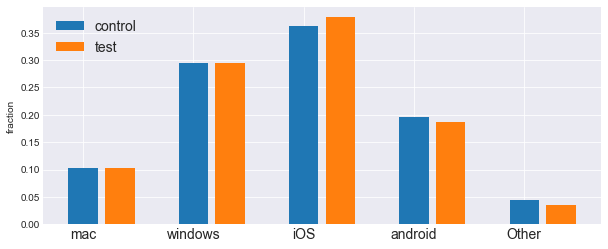

In [16]:
# positive cases only
converted_control = control_group[control_group['converted']==1]
converted_test = test_group[test_group['converted']==1]

onehot_opsys_control = onehot_encode_function(converted_control['operative_system'])
onehot_opsys_test = onehot_encode_function(converted_test['operative_system'])

fig, ax = plt.subplots(figsize=(10,4))
plt.bar(np.arange(0, 15, 3), np.sum(onehot_opsys_control, axis=0)/np.sum(onehot_opsys_control), label='control')
plt.bar(np.arange(1, 16, 3), np.sum(onehot_opsys_test, axis=0)/np.sum(onehot_opsys_test), label='test')
plt.xticks(np.arange(0, 15, 3),list(opsys_cats.keys()), fontsize=14)
plt.legend(loc=2, fontsize=14)
plt.ylabel('fraction')
plt.show()

There doesn't seem to be much of a pattern here - maybe a higher fraction of users on iOS convert relative to Android when the price is higher, but it's not a large effect. 

Now let's look at the sources of converted users:

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  after removing the cwd from sys.path.


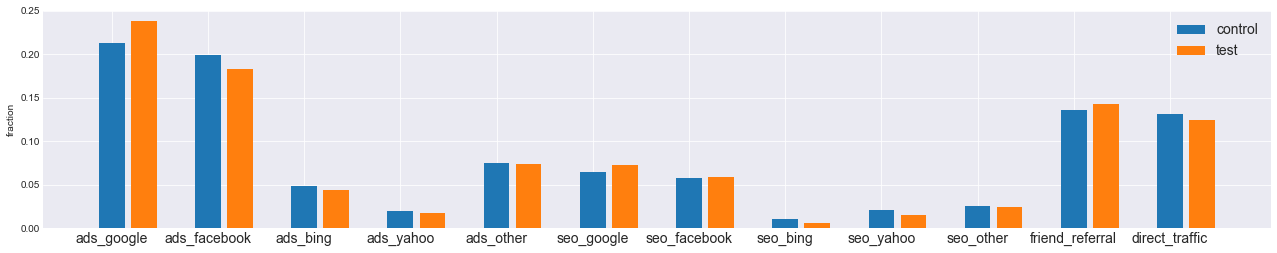

In [17]:
# positive cases only
converted_control = control_group[control_group['converted']==1]
converted_test = test_group[test_group['converted']==1]

onehot_opsys_control = onehot_encode_function(converted_control['source'])
onehot_opsys_test = onehot_encode_function(converted_test['source'])

fig, ax = plt.subplots(figsize=(22,4))
plt.bar(np.arange(0, 36, 3), np.sum(onehot_opsys_control, axis=0)/np.sum(onehot_opsys_control), label='control')
plt.bar(np.arange(1, 37, 3), np.sum(onehot_opsys_test, axis=0)/np.sum(onehot_opsys_test), label='test')
plt.xticks(np.arange(0, 36, 3),list(source_cats.keys()), fontsize=14)
plt.legend(loc=1, fontsize=14)
plt.ylabel('fraction')
plt.show()

Aha - it looks like in the test group that Google-sourced users were more likely to convert than Facebook-source users, relative to the control group. It's not immediately clear why this would be, but we can test the significance of the difference with a Chi-squared test, which compares distributions of categorical variables. Our null hypothesis here is that there is no difference between the test and control groups.

In [18]:
# count Google, Facebook conversions in the control and test groups
control_google = converted_control[converted_control['source']==0.0]['source'].count()
test_google = converted_test[converted_test['source']==0.0]['source'].count()
control_fb = converted_control[converted_control['source']==1.0]['source'].count()
test_fb = converted_test[converted_test['source']==1.0]['source'].count()


test_pop = [test_google, test_fb]
control_pop = [control_google, control_fb]
norm_factor = sum(test_pop)/sum(control_pop)
control_pop = [int(i*norm_factor) for i in control_pop]
# small issue with the total of the two samples being different - adjust by downscaling the control pop to have 
# total size = test pop (this will lower significance, which is okay)
chisq, pval_chi = chisquare(control_pop, test_pop)
print('Chi-squared p-value:',pval_chi)

Chi-squared p-value: 0.006847648891839333


This doesn't meet our 3-sigma threshold we used previously, but as this is a less high-stakes insight we might be able to accept a 2-sigma (95%) significance level. 

There are a few ways forward with this insight - we could step up Google advertising, since that channel has a higher conversion rate than Facebook, or we could try and incentivize Facebook users with deals, etc. The best way may be a mix of both. 

# 4. Conclusion

To briefly summarize, we conducted a followup analysis of an A/B test designed to determine the effects of increasing the price of a software product. Data was collected by randomly presenting users with the normal software price (the control group) and a 50% increased price (the test group) over a period of 3 months. 

### Key Insights
* **Effects of increasing the price on conversion rate.** As expected, increasing the software price decreased conversion rate over the test period by 22% (>99.99% confidence). If the higher price is adopted, it may be worth conducting periodic longer-term conversion rate monitoring to ensure that, e.g., increased price dissatisfaction and a corresponding drop in referrals doesn't result in steadily declining sales over the long term.

* **Effects of increasing the price on total revenue.** While conversion rate decreased by 22%, net revenue per test user actually increased by 18% relative to the control group (>99.99 confidence), due to the higher price of the software.

* **Retaining customers under an increase in price.** Considering the test group, analysis shows with high confidence (>95%) that the fraction of conversions coming from Google ads increased while those coming from Facebook ads decreased. If the higher pricing is adopted, incentive programs can be designed to maintain the current Facebook conversion rate and/or Google ads can be increased to reach additional users. 

* **A/B testing efficiency.** If the primary goal was to address the two above questions, then analysis shows that a high level of confidence (99.7%) could have been reached with approximately 10% of the total data. However, the customer retention analysis above was only made possible by the large sample we collected. My recommendation is to first define the goals of the A/B test and a level of significance desired, then design the test to meet those objectives. 